## Прогнозирование вероятности оттока пользователей для фитнес-центров

### Описание проекта

#### Задача

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

#### Описание данных

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;

- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

Путь к файлу: /datasets/gym_churn.csv.

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

### Исследовательский анализ данных (EDA)

In [2]:
#Читаем данные
df=pd.read_csv('/datasets/gym_churn.csv')

In [3]:
#Смотрим что тут
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
#Называем столбцы строчными буквами
df.columns = df.columns.str.lower()

In [5]:
#Смотрим инфо. пропусков нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [6]:
#Смотрим дубликаты. Их тоже нет.
df.duplicated().sum()

0

In [7]:
#изучим средние значения и стандартные отклонения
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


- Разделение по Гендерному признаку практически один к одному;
- Порядка 84% клиентов живут неподалеку;
- 50% клиентов являются  сотрудниками компании-партнёра клуба;
- 30% клиентов привели по акции друзья;
- 90% клиентов оставили свой контактный телефон;
- Средняя длительность абонементов 4.6 месяцев;
- Порядка 40% клиентов посещаяю групповые занятия;
- Средний возраст 29 лет;
- 146 у.е. в среднем тратит клиент на другие услуги в зале;
- До конца контракта в среднем 4.3 месяца;
- В среднем клиент "живет" 3.7 месяца;
- В среднем зал посещают 1-2 раза в неделю;
- В предыдущем месяце так же в среднем посещение не превышает двух раз;
- Отток в прошлом месяце составил 27%.

In [8]:
#Посмотриv на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
df.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


###### Портрет в оттоке:
Пол не имеет значения, клиент скорее всего живет не в непосредственной близости к клубу, пришел не по партнерской скидочной программе, редко посещает групповые занятия, в среднем занимается около месяца.

#### Построим столбчатые гистограммы и распределения признаков для тех, кто ушел и тех, кто остался.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


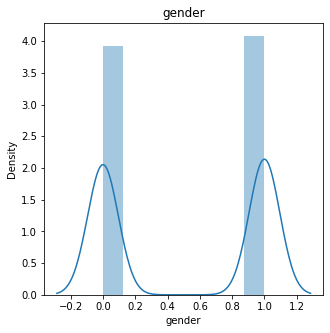

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


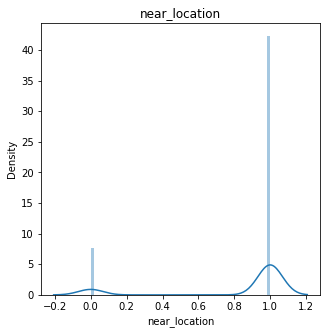

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


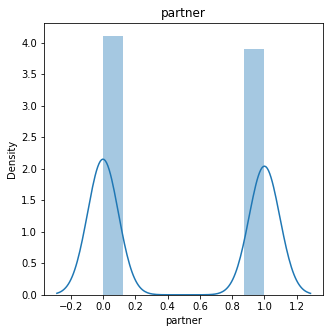

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


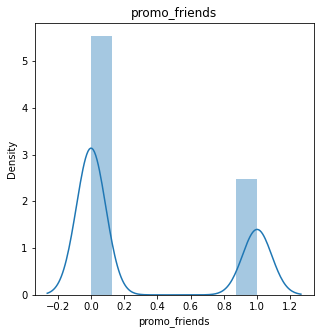

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


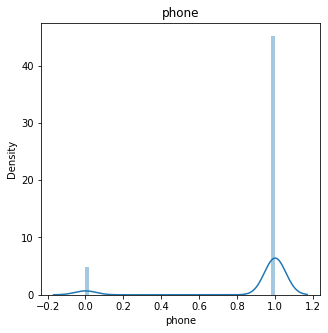

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


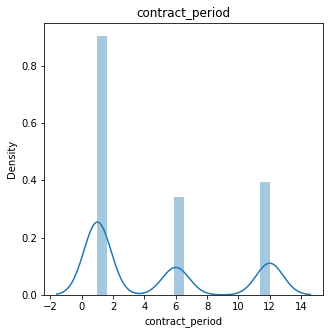

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


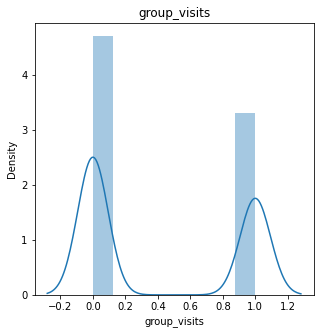

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


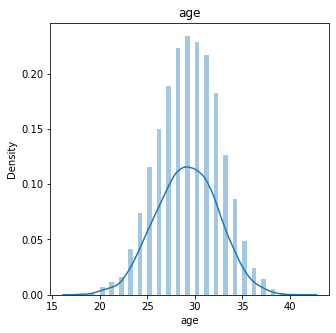

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


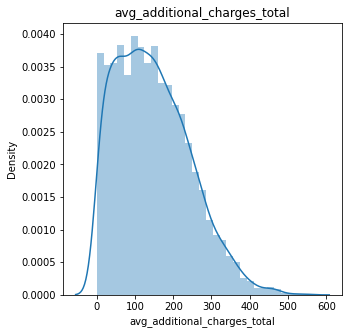

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


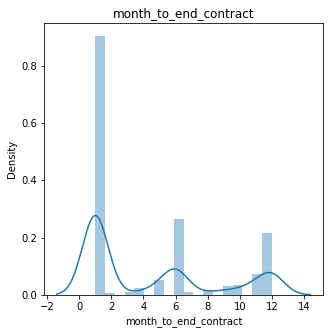

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


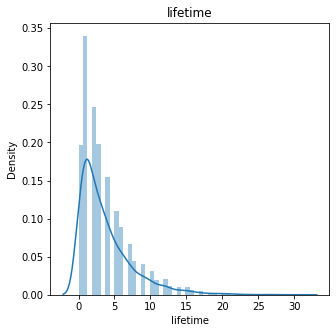

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


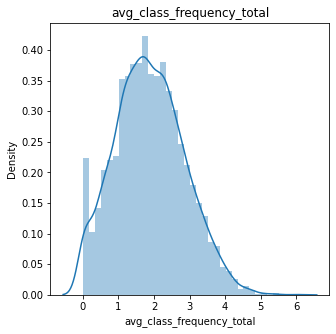

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


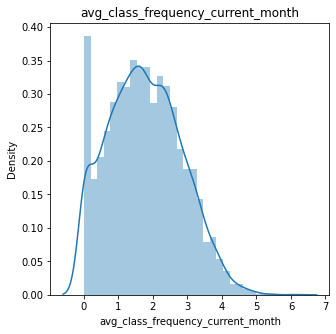

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


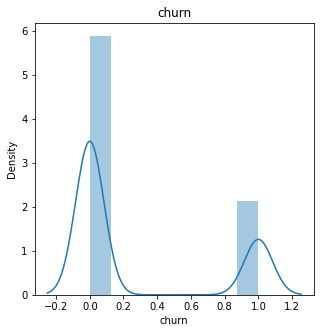

In [9]:
for column in df.columns:
    plt.figure(figsize=(5, 5))
    df.groupby('churn')[column]
    sns.distplot(df[column])
    plt.title(column)
    plt.show()

#### Построим матрицу корреляций и отобразим её

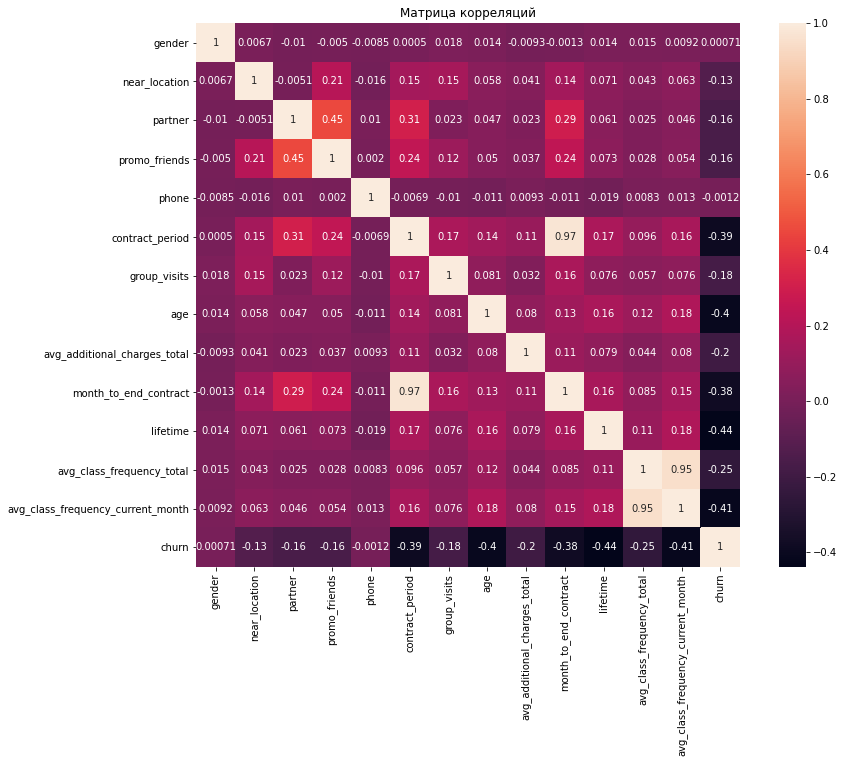

In [10]:
plt.figure(figsize=(14,10))
sns.heatmap(data = df.corr(), annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

Явной корреляции нет ни с одним  признаком.

Имеются два мультиколлинеарных признака - contract_period и month_to_end_contact, но они не влияют на отток. Оставим их.


### Построение модели прогнозирования оттока пользователей

###### Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

- Разобьем данные на обучающую и валидационную выборку функцией train_test_split().
- Обучим модель на train-выборке двумя способами:
  логистической регрессией,
  случайным лесом.
- Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

In [11]:
X = df.drop(['churn'], axis = 1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
print('Метрики для модели логистической регрессии:')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, lr_predictions),
    precision_score(y_test, lr_predictions),
    recall_score(y_test, lr_predictions)
))

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print('\nМетрики для модели случайного леса:')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, rf_predictions),
    precision_score(y_test, rf_predictions),
    recall_score(y_test, rf_predictions)
))

features = pd.DataFrame(lr_model.coef_.T, X.columns).reset_index()
features.columns = ['feature', 'coef']
features['coef'] = features['coef'].apply(lambda x: abs(x))
features = features.sort_values(by='coef', ascending=False)
print('\nКоэффициенты признаков в оптимальной функции логистической регрессии:')
print(features)

Метрики для модели логистической регрессии:
accuracy_score: 0.9225
precision_score: 0.8541666666666666
recall_score:0.8282828282828283

Метрики для модели случайного леса:
accuracy_score: 0.915
precision_score: 0.8385416666666666
recall_score:0.8131313131313131

Коэффициенты признаков в оптимальной функции логистической регрессии:
                              feature      coef
12  avg_class_frequency_current_month  4.454231
10                           lifetime  3.846281
11          avg_class_frequency_total  3.299788
7                                 age  1.091431
5                     contract_period  0.719095
8        avg_additional_charges_total  0.552164
9               month_to_end_contract  0.534026
6                        group_visits  0.393453
3                       promo_friends  0.275671
2                             partner  0.081512
1                       near_location  0.075644
0                              gender  0.013079
4                               phone  0.00

###### Вывод:

Доля верных прогнозов и полнота в целом похожи у обоих моделей, но модель логистической регрессии всё же впереди.

Берем ее.


### Кластеризацию клиентов

###### Отложим в сторону столбец с оттоком и проведем кластеризацию объектов (клиентов):

- Стандартизируем данные.
- Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.
- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5
- Посмотрим на средние значения признаков для кластеров.
- Построим распределения признаков для кластеров.
- Для каждого полученного кластера посчитаем долю оттока.

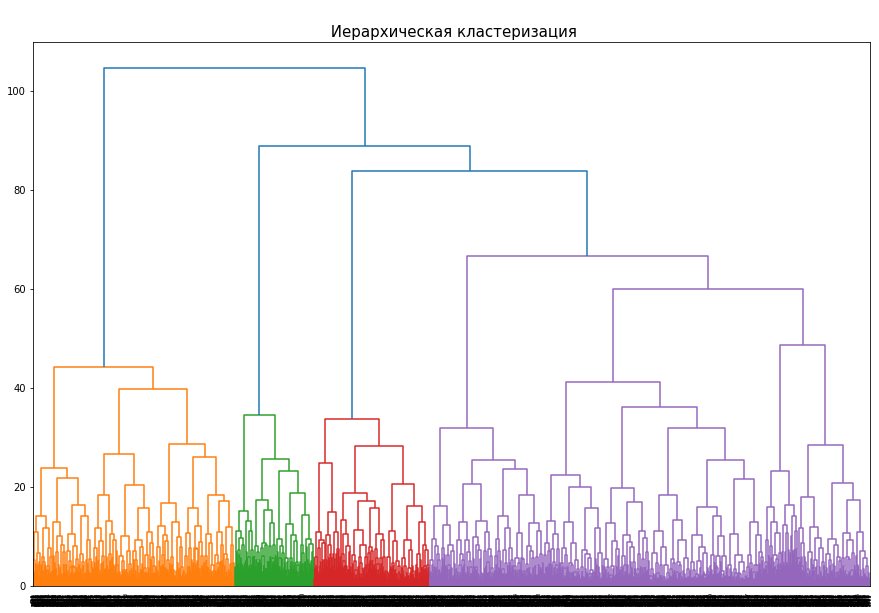

In [12]:
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('\n Иерархическая кластеризация', fontsize=15)
plt.show()
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_st)
df['cluster_km'] = labels

Выделяются 4 группы, но по заданию мы используем пять.


#### Посмотрим на средние значения признаков для кластеров

In [13]:
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


#### Построим распределения признаков для кластеров.

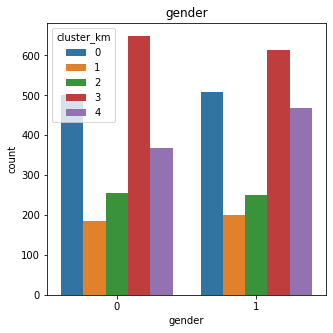

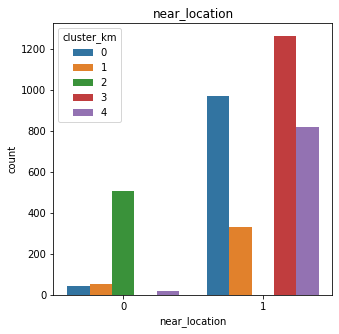

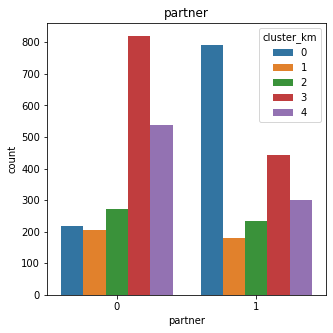

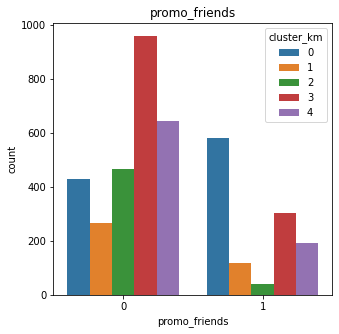

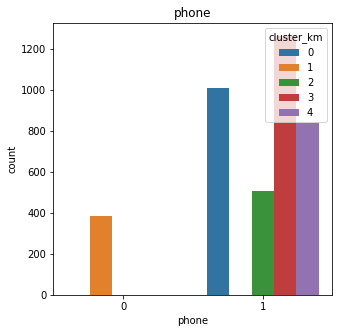

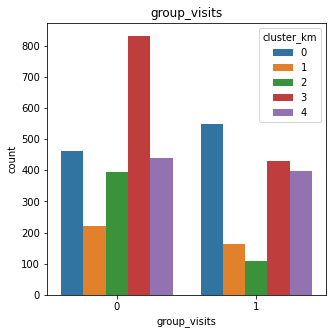

In [14]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='cluster_km', data=df)
    plt.title(column)
    plt.show()

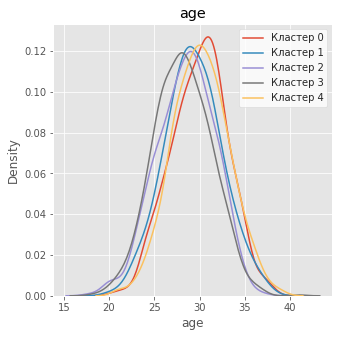

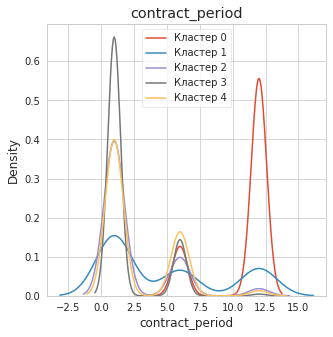

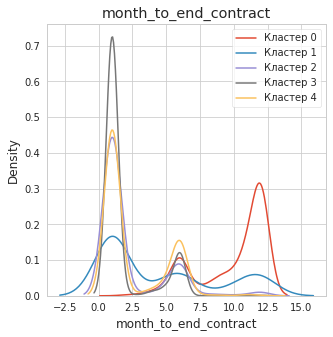

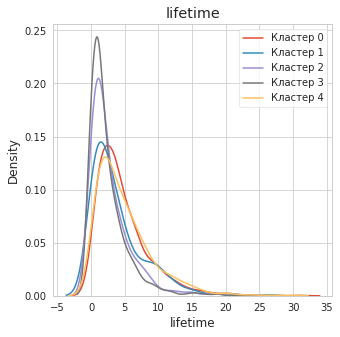

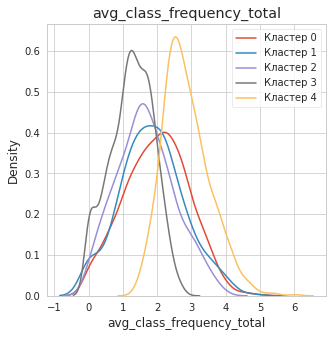

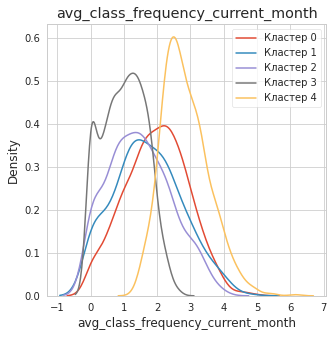

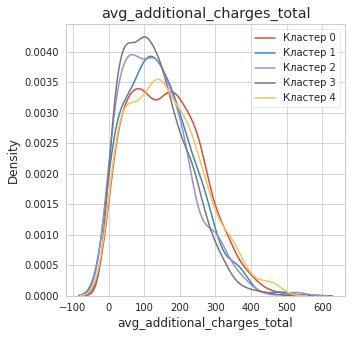

In [15]:
matplotlib.style.use('ggplot')
for column in ['age', 'contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']:
    plt.figure(figsize=(5, 5))
    plt.title(column)   
    sns.kdeplot(df.query('cluster_km==0')[column], label = 'Кластер 0')
    sns.kdeplot(df.query('cluster_km==1')[column], label = 'Кластер 1')
    sns.kdeplot(df.query('cluster_km==2')[column], label = 'Кластер 2')
    sns.kdeplot(df.query('cluster_km==3')[column], label = 'Кластер 3')
    sns.kdeplot(df.query('cluster_km==4')[column], label = 'Кластер 4')
    
    sns.set_style('whitegrid')
    plt.legend()
    plt.show()

###### Кластеры:

###### Кластер 0
- Отток - 2%
- Живут недалеко от фитнес-центра
- Длительные абонименты
- Много тратят на другие услуги клуба
- долгий лайфтайм
- Часто ходят в зал

###### Кластер 1
- Отток - 27%
- Живут недалеко от фитнес-центра
- Не оставляют номеров
- Контракт в среднем на 5 месяцев
- Часто ходят в зал

###### Кластер 2
- Отток - 44% - самый низкий
- Живут далеко от фитнес-центра
- Малый процент приглашения от друзей
- Контракт на 2 месяца
- Не посещают групповые
- Ходят 1-2 раза в неделю

###### Кластер 3
- Отток - 51%
- Живут недалеко от фитнес-центра
- Малый процент приглашения от друзей
- Контракт на 2 месяца
- Не посещают групповые
- Ходят 1 раз в неделю
- Тратят меньше остальных на сопутствующие товары

###### Кластер 4
- Отток - 7%
- Живут недалеко от фитнес-центра
- Много тратят на сопутствующие товары
- Средний абонимент 3 месяца
- Ходят по 3 раза в неделю


### Выводы и рекомендации отделу по работе с клиентами:

У Сети фитнес-центров «Культурист-датасаентист» комфортно заниматься людям, живущим неподалеку от зала, они ходят в зал регулярно и покупают абонемент надолго. Как правило, у них есть Скидки от партнеров и бонусы от друзей по залу. Они тратят в зале деньги на доп. услуги и частенько ходят на групповые занятия. Если коротко, то идеальные клиенты, это мотивированные спортсмены, которые занимаются давно.

Противоположные им начинающие культуристы. Самый большой отток от них. Самые короткие абонементы, зал не в их районе, ходят на тренировки редко.

Рекомендации можно дать по двум направлениям:

- Замотивировать новичков бесплатными занятиями с тренером и бонусами на групповые занятия. Так сказать подсадить

- Развернуть рекламную компанию по мотивированию новых клиентов сразу покупать длительный абонемент.  Старички и так покупают "долгие абонементы", а новички смогут приносить больше прибыли платя за полгода сразу.
